In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mohammedalrajeh/quran-recitations-for-audio-classification")

# Production level Audio Classification

In [2]:
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 26.4 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import librosa
import librosa.display
import numpy as np
import pandas as pd
from skimage.transform import resize # Using skimage for resizing spectrogram
import os
import time
import copy # For saving best model weights
import joblib # For saving/loading LabelEncoder
import torchmetrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

In [4]:
# --- Configuration ---
# Data Paths
CSV_PATH = "/content/quran-recitations-for-audio-classification/files_paths.csv"
BASE_AUDIO_DIR = "/content/quran-recitations-for-audio-classification/Dataset"

# Model Saving
MODEL_SAVE_PATH = "best_audio_cnn_model.pth"
ENCODER_SAVE_PATH = "audio_label_encoder.joblib"

# Feature Extraction Parameters
SAMPLE_RATE = 22050
DURATION = 5 # seconds
N_MELS = 128 # Height of spectrogram
SPEC_WIDTH = 256 # Target width of spectrogram (time dimension)
N_FFT = 2048
HOP_LENGTH = 512

# Training Parameters
BATCH_SIZE = 32 # Adjusted batch size
EPOCHS = 50 # Adjusted epochs, early stopping will likely trigger sooner
LEARNING_RATE = 1e-4
RANDOM_STATE = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 2
EARLY_STOPPING_PATIENCE = 7 # Increased patience slightly
print(f"Using device: {DEVICE}")

Using device: cuda


## --- 1. Data Loading and Preparation ---

In [5]:
def load_and_prepare_data(csv_path, base_audio_dir):
    """Loads CSV, corrects paths, encodes labels, and splits data."""
    try:
        df = pd.read_csv(csv_path)
        # Correct file paths
        df['FilePath'] = base_audio_dir + df['FilePath'].str[1:]
        # Ensure 'Class' column exists
        if 'Class' not in df.columns:
            raise ValueError("CSV must contain a 'Class' column for labels.")

        print(f"Initial data shape: {df.shape}")
        print(f"Class distribution:\n{df['Class'].value_counts()}")

        # Encode string labels to integers
        label_encoder = LabelEncoder()
        df['label_idx'] = label_encoder.fit_transform(df['Class'])
        num_classes = len(label_encoder.classes_)
        print(f"\nNumber of classes found: {num_classes}")
        print(f"Class mapping: {dict(zip(label_encoder.classes_, range(num_classes)))}")

        # Split data (Train/Val/Test: 70%/15%/15%)
        train_df, temp_df = train_test_split(
            df,
            test_size=0.3,
            random_state=RANDOM_STATE,
            stratify=df['label_idx'] # Stratify based on encoded labels
        )
        val_df, test_df = train_test_split(
            temp_df,
            test_size=0.5,
            random_state=RANDOM_STATE,
            stratify=temp_df['label_idx']
        )

        print(f"\nDataset split:")
        print(f"Train: {len(train_df)} samples")
        print(f"Validation: {len(val_df)} samples")
        print(f"Test: {len(test_df)} samples")

        # Save the fitted encoder
        joblib.dump(label_encoder, ENCODER_SAVE_PATH)
        print(f"LabelEncoder saved to {ENCODER_SAVE_PATH}")

        return train_df, val_df, test_df, num_classes, label_encoder

    except FileNotFoundError:
        raise ValueError(f"CSV file not found at {csv_path}")
    except Exception as e:
        raise RuntimeError(f"Error during data loading/preparation: {e}")

try:
    train_df, val_df, test_df, NUM_CLASSES, label_encoder = load_and_prepare_data(CSV_PATH, BASE_AUDIO_DIR)
except (ValueError, RuntimeError) as e:
    print(str(e))
    # exit()

Initial data shape: (6687, 2)
Class distribution:
Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64

Number of classes found: 12
Class mapping: {'AbdulBari_Althubaity': 0, 'AbdulRahman_Alsudais': 1, 'Abdullah_Albuaijan': 2, 'Ali_Alhothaify': 3, 'Bander_Balilah': 4, 'Maher_Almuaiqly': 5, 'Mohammed_Aluhaidan': 6, 'Mohammed_Ayoub': 7, 'Nasser_Alqutami': 8, 'Saad_Alghamdi': 9, 'Saud_Alshuraim': 10, 'Yasser_Aldossary': 11}

Dataset split:
Train: 4680 samples
Validation: 1003 samples
Test: 1004 samples
LabelEncoder saved to audio_label_encoder.joblib


## --- 2. Spectrogram Extraction Function ---

In [6]:
def get_spectrogram(file_path, sr=SAMPLE_RATE, duration=DURATION, n_mels=N_MELS, img_width=SPEC_WIDTH):
    """Loads audio, computes Mel Spectrogram, converts to dB, and resizes."""
    try:
        # Load audio, resample, trim/pad
        # Use res_type='kaiser_fast' for potentially faster loading
        with warnings.catch_warnings(): # Suppress librosa warnings if needed
            warnings.simplefilter("ignore")
            signal, current_sr = librosa.load(file_path, sr=sr, duration=duration, res_type='kaiser_fast')

        # Pad signal if shorter than duration * sr (important for fixed size)
        expected_length = sr * duration
        if len(signal) < expected_length:
            signal = np.pad(signal, (0, expected_length - len(signal)), 'constant')

        # Compute Mel Spectrogram
        spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=n_mels)
        # Convert to dB
        spec_db = librosa.power_to_db(spec, ref=np.max)

        # Ensure consistent time dimension length BEFORE resizing (more robust)
        # expected_time_frames = int(np.ceil(expected_length / HOP_LENGTH)) # Rough calculation
        # if spec_db.shape[1] < expected_time_frames:
        #     spec_db = np.pad(spec_db, ((0,0), (0, expected_time_frames - spec_db.shape[1])), mode='constant', constant_values=np.min(spec_db))
        # elif spec_db.shape[1] > expected_time_frames:
        #     spec_db = spec_db[:, :expected_time_frames]

        # Resize using skimage - Ensure output is float32 for PyTorch
        spec_resized = resize(spec_db, (n_mels, img_width), anti_aliasing=True, mode='constant', preserve_range=True) # preserve_range for dB
        return spec_resized.astype(np.float32)

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None # Return None on error

## --- 3. Custom PyTorch Dataset (On-the-fly processing) ---

In [7]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        # Store paths and numerical labels
        self.file_paths = dataframe['FilePath'].tolist()
        self.labels = dataframe['label_idx'].tolist()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_path = self.file_paths[idx]
        label = self.labels[idx]

        # Generate spectrogram on the fly
        spectrogram = get_spectrogram(audio_path)

        # Handle potential errors during spectrogram generation
        if spectrogram is None:
            print(f"Warning: Spectrogram for index {idx} ({audio_path}) is None. Returning dummy data.")
            # Return dummy data matching expected dimensions, and a special label maybe
            spectrogram = np.zeros((N_MELS, SPEC_WIDTH), dtype=np.float32)
            label = -1 # Or another way to flag invalid data

        # Convert to tensor, add channel dimension
        # Data is kept on CPU here, moved to DEVICE in training loop
        audio_tensor = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
        label_tensor = torch.tensor(label, dtype=torch.long)

        return audio_tensor, label_tensor

## --- 4. Create Datasets and DataLoaders ---

In [8]:
train_dataset = CustomAudioDataset(train_df)
val_dataset = CustomAudioDataset(val_df)
test_dataset = CustomAudioDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True if DEVICE == "cuda" else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if DEVICE == "cuda" else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True if DEVICE == "cuda" else False)

print("\nDatasets and DataLoaders created.")


Datasets and DataLoaders created.


## --- 5. Define the CNN Model (with BatchNorm and dynamic sizing) ---

In [9]:
class Net(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        # Convolutional layers with BatchNorm
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.flatten = nn.Flatten()

        # Calculate flattened size dynamically
        # Perform a dummy forward pass with a sample input tensor
        with torch.no_grad():
            # Use cpu explicitly for this calculation
            dummy_input_cpu = torch.zeros(1, 1, N_MELS, SPEC_WIDTH)
            x = self.conv_block1(dummy_input_cpu)
            x = self.conv_block2(x)
            x = self.conv_block3(x)
            flattened_size = self.flatten(x).shape[1] # Get the size after flattening
            print(f"Calculated flattened size for linear layers: {flattened_size}")

        # Fully connected layers with Dropout
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_size, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes) # Output raw logits
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = self.fc_block(x)
        return x

model = Net(num_classes=NUM_CLASSES).to(DEVICE)
print("\nModel created.")

Calculated flattened size for linear layers: 32768

Model created.


In [10]:
# Optional: Print summary
try:
    from torchsummary import summary
    # Correct input size (Channels, Height, Width)
    summary(model, input_size=(1, N_MELS, SPEC_WIDTH))
except ImportError:
    print("\nInstall torchinfo for model summary: pip install torchsummary")
except Exception as e:
    print(f"\nCould not print model summary: {e}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
       BatchNorm2d-2         [-1, 16, 128, 256]              32
              ReLU-3         [-1, 16, 128, 256]               0
         MaxPool2d-4          [-1, 16, 64, 128]               0
            Conv2d-5          [-1, 32, 64, 128]           4,640
       BatchNorm2d-6          [-1, 32, 64, 128]              64
              ReLU-7          [-1, 32, 64, 128]               0
         MaxPool2d-8           [-1, 32, 32, 64]               0
            Conv2d-9           [-1, 64, 32, 64]          18,496
      BatchNorm2d-10           [-1, 64, 32, 64]             128
             ReLU-11           [-1, 64, 32, 64]               0
        MaxPool2d-12           [-1, 64, 16, 32]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                 [-

## --- 6. Loss, Optimizer, Scheduler, Metrics ---

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

train_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
val_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)


## --- 7. Training and Validation Functions ---

In [12]:
def train_one_epoch(model, loader, criterion, optimizer, device, metric):
    model.train()
    running_loss = 0.0
    metric.reset()
    num_samples = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
         # Filter potentially invalid data flagged by Dataset
        valid_indices = labels != -1
        if not valid_indices.all():
            inputs = inputs[valid_indices]
            labels = labels[valid_indices]
            if inputs.shape[0] == 0: continue # Skip empty batch

        inputs, labels = inputs.to(device), labels.to(device)
        num_samples += inputs.size(0)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        metric.update(outputs, labels)

    # Avoid division by zero
    avg_loss = running_loss / num_samples if num_samples > 0 else 0.0
    epoch_acc = metric.compute()
    return avg_loss, epoch_acc.item()


def validate_one_epoch(model, loader, criterion, device, metric):
    model.eval()
    running_loss = 0.0
    metric.reset()
    num_samples = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            valid_indices = labels != -1
            if not valid_indices.all():
                inputs = inputs[valid_indices]
                labels = labels[valid_indices]
                if inputs.shape[0] == 0: continue

            inputs, labels = inputs.to(device), labels.to(device)
            num_samples += inputs.size(0)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            metric.update(outputs, labels)

    # Avoid division by zero
    avg_loss = running_loss / num_samples if num_samples > 0 else 0.0
    epoch_acc = metric.compute()
    return avg_loss, epoch_acc.item()

## --- 8. Main Training Loop ---

In [13]:
!pip install resampy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.2 MB/s eta 0:00:00


In [14]:
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')
best_model_wts = None
patience_counter = 0

print("\nStarting Training...")
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE, train_accuracy)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, DEVICE, val_accuracy)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{EPOCHS} [{epoch_duration:.2f}s] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss) # Step based on validation loss

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        print(f"Validation loss improved ({best_val_loss:.4f} -> {val_loss:.4f}). Saving model...")
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, MODEL_SAVE_PATH)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

total_training_time = time.time() - start_time
print(f"\nTraining Finished. Total time: {total_training_time:.2f}s")
print(f"Best Validation Loss: {best_val_loss:.4f}")


Starting Training...


Epoch 1/50 [430.15s] - Train Loss: 2.4901, Train Acc: 0.1316 | Val Loss: 2.2111, Val Acc: 0.2014
Validation loss improved (inf -> 2.2111). Saving model...


Epoch 2/50 [406.32s] - Train Loss: 1.9003, Train Acc: 0.3449 | Val Loss: 0.9502, Val Acc: 0.7468
Validation loss improved (2.2111 -> 0.9502). Saving model...


Epoch 3/50 [408.26s] - Train Loss: 0.8591, Train Acc: 0.7026 | Val Loss: 0.3587, Val Acc: 0.8843
Validation loss improved (0.9502 -> 0.3587). Saving model...


Epoch 4/50 [411.92s] - Train Loss: 0.4493, Train Acc: 0.8573 | Val Loss: 0.1940, Val Acc: 0.9372
Validation loss improved (0.3587 -> 0.1940). Saving model...


Epoch 5/50 [408.97s] - Train Loss: 0.2753, Train Acc: 0.9107 | Val Loss: 0.1113, Val Acc: 0.9641
Validation loss improved (0.1940 -> 0.1113). Saving model...


Epoch 6/50 [409.75s] - Train Loss: 0.1561, Train Acc: 0.9481 | Val Loss: 0.1017, Val Acc: 0.9651
Validation loss improved (0.1113 -> 0.1017). Saving model...


Epoch 7/50 [411.86s] - Train Loss: 0.1302, Train Acc: 0.9622 | Val Loss: 0.0914, Val Acc: 0.9731
Validation loss improved (0.1017 -> 0.0914). Saving model...


Epoch 8/50 [404.76s] - Train Loss: 0.0798, Train Acc: 0.9752 | Val Loss: 0.0540, Val Acc: 0.9850
Validation loss improved (0.0914 -> 0.0540). Saving model...


Epoch 9/50 [406.31s] - Train Loss: 0.0795, Train Acc: 0.9735 | Val Loss: 0.0476, Val Acc: 0.9850
Validation loss improved (0.0540 -> 0.0476). Saving model...


Epoch 10/50 [409.26s] - Train Loss: 0.0607, Train Acc: 0.9814 | Val Loss: 0.0319, Val Acc: 0.9910
Validation loss improved (0.0476 -> 0.0319). Saving model...


Epoch 11/50 [407.70s] - Train Loss: 0.0513, Train Acc: 0.9846 | Val Loss: 0.0360, Val Acc: 0.9880


Epoch 12/50 [406.59s] - Train Loss: 0.0550, Train Acc: 0.9840 | Val Loss: 0.0241, Val Acc: 0.9900
Validation loss improved (0.0319 -> 0.0241). Saving model...


KeyboardInterrupt: 

## --- 9. Plot Training History ---

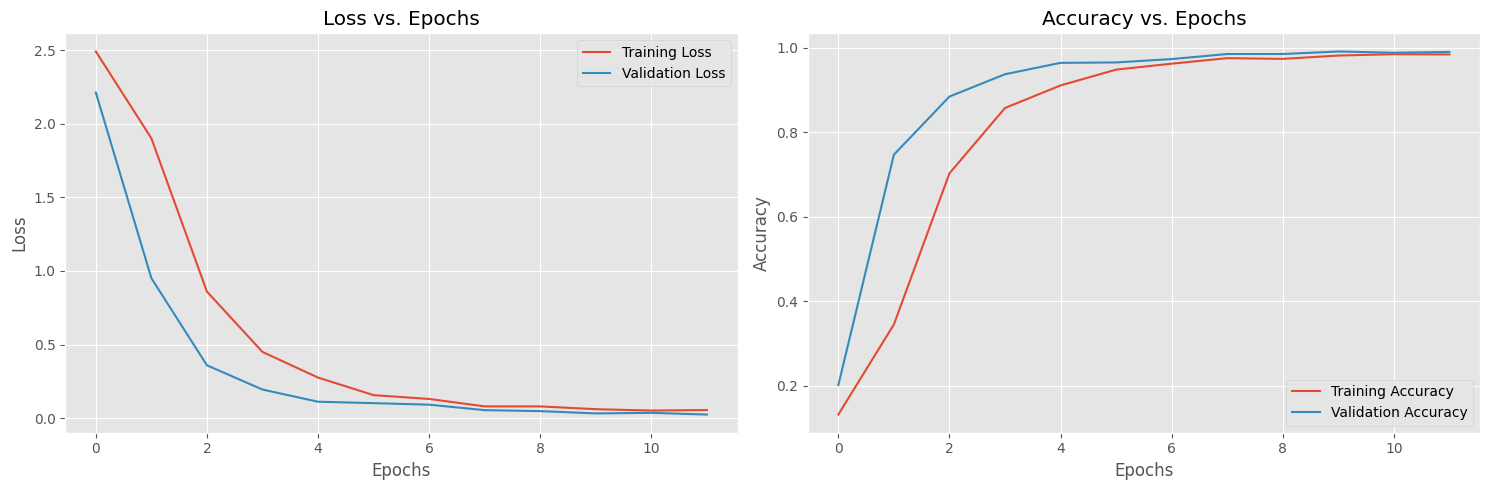

In [15]:
plt.style.use('ggplot')
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history['train_loss'], label='Training Loss')
axs[0].plot(history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss vs. Epochs'); axs[0].set_xlabel('Epochs'); axs[0].set_ylabel('Loss'); axs[0].legend()
axs[1].plot(history['train_acc'], label='Training Accuracy')
axs[1].plot(history['val_acc'], label='Validation Accuracy')
axs[1].set_title('Accuracy vs. Epochs'); axs[1].set_xlabel('Epochs'); axs[1].set_ylabel('Accuracy'); axs[1].legend()
plt.tight_layout(); plt.show()

## --- 10. Final Testing ---

In [16]:
print("\nEvaluating on Test Set using best model weights...")
if best_model_wts:
    model.load_state_dict(best_model_wts)
else:
    print("Warning: No best model weights saved. Evaluating with final weights.")

test_loss, test_acc = validate_one_epoch(model, test_loader, criterion, DEVICE, val_accuracy) # Reuse validate function
print(f"\nFinal Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.4f}")



Evaluating on Test Set using best model weights...



Final Test Loss: 0.0419, Final Test Accuracy: 0.9851


In [17]:
# Optional: Detailed classification report
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        valid_indices = labels != -1
        if not valid_indices.all():
            inputs = inputs[valid_indices]
            labels = labels[valid_indices]
            if inputs.shape[0] == 0: continue

        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

if all_preds and all_labels:
    try:
        print("\nClassification Report (Test Set):")
        print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
    except Exception as e:
        print(f"Could not generate classification report: {e}")
else:
    print("No predictions made on test set, skipping classification report.")



Classification Report (Test Set):
                      precision    recall  f1-score   support

AbdulBari_Althubaity       1.00      1.00      1.00        68
AbdulRahman_Alsudais       0.99      1.00      0.99        97
  Abdullah_Albuaijan       1.00      0.99      0.99        75
      Ali_Alhothaify       1.00      0.98      0.99        87
      Bander_Balilah       0.97      0.99      0.98        87
     Maher_Almuaiqly       1.00      1.00      1.00        87
  Mohammed_Aluhaidan       1.00      0.97      0.99        68
      Mohammed_Ayoub       0.99      0.96      0.97        72
     Nasser_Alqutami       0.94      0.99      0.96        68
       Saad_Alghamdi       0.99      0.99      0.99       103
      Saud_Alshuraim       0.97      0.99      0.98       105
    Yasser_Aldossary       0.98      0.97      0.97        87

            accuracy                           0.99      1004
           macro avg       0.99      0.98      0.98      1004
        weighted avg       0.99  

## --- 11. Inference Function ---

In [19]:
def predict_audio_file(file_path, model_path, encoder_path, device):
    """Loads model and encoder, processes audio file, predicts class name."""
    try:
        # Load the fitted label encoder
        le = joblib.load(encoder_path)
        num_classes_inf = len(le.classes_)

        # Process the audio file to get spectrogram
        spectrogram = get_spectrogram(file_path)
        if spectrogram is None:
            return "Error processing audio file.", 0.0

        # Convert to tensor, add channel & batch dim, move to device
        input_tensor = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        # Load model structure and weights
        inf_model = Net(num_classes=num_classes_inf).to(device)
        inf_model.load_state_dict(torch.load(model_path, map_location=device))
        inf_model.eval()

        # Predict
        with torch.no_grad():
            output = inf_model(input_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, predicted_idx = torch.max(probabilities, 1)
            predicted_label_name = le.inverse_transform([predicted_idx.item()])[0]

        return predicted_label_name, confidence.item()

    except FileNotFoundError:
        return f"Error: File not found ({file_path}, {model_path}, or {encoder_path}).", 0.0
    except Exception as e:
        return f"An error occurred during prediction: {e}", 0.0


In [20]:
# --- Example Inference ---
# Use a file from the test set for example
if len(test_df) > 0 and os.path.exists(MODEL_SAVE_PATH) and os.path.exists(ENCODER_SAVE_PATH):
    example_audio_path = test_df['FilePath'].iloc[0]
    true_label_idx = test_df['label_idx'].iloc[0]
    true_label_name = label_encoder.inverse_transform([true_label_idx])[0]

    predicted_class, confidence_score = predict_audio_file(
        example_audio_path,
        MODEL_SAVE_PATH,
        ENCODER_SAVE_PATH,
        DEVICE
    )
    print(f"\nInference on '{os.path.basename(example_audio_path)}':")
    print(f"True Class: {true_label_name} (Index: {true_label_idx})")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence_score:.4f}")
else:
    print("\nSkipping inference example: Test data or saved model/encoder not found.")

Calculated flattened size for linear layers: 32768

Inference on 'Saud_149.wav':
True Class: Saud_Alshuraim (Index: 10)
Predicted Class: Saud_Alshuraim
Confidence: 0.9956
